# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [232]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler

plt.style.use(['dark_background'])

In [233]:
orange_small_churn_data = pd.read_csv('./data/orange_small_churn_data.txt')
orange_small_churn_labels = pd.read_csv('./data/orange_small_churn_labels.txt', header=None, names=['target'])

2\. Рассчитайте доли классов `отток` и `не отток`.

Посмотрим на гистограмму распределения таргета и на доли классов

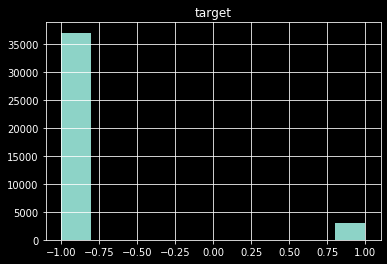

In [234]:
orange_small_churn_labels.hist();

In [6]:
orange_small_churn_labels['target'].value_counts(normalize=True)*100

-1    92.56
 1     7.44
Name: target, dtype: float64

Доля оттока всего 7,4% - выборка несбалансированная

Посмотрим, во сколько раз доля not churn больше churn

In [235]:
(orange_small_churn_labels['target']==-1).sum() / (orange_small_churn_labels['target']==1).sum()

12.440860215053764

Сбалансируем нашу выборку, для того, чтобы визуально легче было проводить EDA, т.к. мы будем работать с агрегированными данными, это не должно ни на что повлиять

In [224]:
while (df_all['target']==-1).sum() / (df_all['target']==1).sum() > 1:
    df_all = pd.concat([df_all, df_all[df_all['target']==1]], axis=0, sort=False)
print((df_all['target']==-1).sum() / (df_all['target']==1).sum())

0.777553763441


In [309]:
df_all = pd.concat([orange_small_churn_data, orange_small_churn_labels], axis=1, sort=False)

In [271]:
df_all['target'].value_counts(normalize=True)*100

-1    92.56
 1     7.44
Name: target, dtype: float64

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция представляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, однако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: 
https://www.coursera.org/learn/stats-for-data-analysis/lecture/prX3S/video-subtitles

In [310]:
# дропнем пустые признаки
df_all = df_all.dropna(axis=1, how='all')

In [311]:
# дропнем константные признаки
nuniq_val = df_all.nunique()
df_all = df_all.drop(nuniq_val[nuniq_val==1].index, axis=1)

In [312]:
num_col = df_all.drop('target', axis=1).dtypes[(df_all.dtypes==np.float64) | (df_all.dtypes==np.int64)].index
category_col = df_all.dtypes[df_all.dtypes==object].index

In [275]:
# кол-во категориальных и численных признаков
len(category_col), len(num_col)

(34, 173)

In [313]:
# заполним пропуски
# для категориальных "-"
df_all[category_col] = df_all[category_col].fillna('-')
# для численных - среднее
df_all[num_col] = df_all[num_col].fillna(df_all[num_col].mean())

In [314]:
# сделаем скелинг численных признаков
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(df_all[num_col].as_matrix())
df_all[num_col] = pd.DataFrame(scaled_matrix, columns=num_col)

C:\Users\pavel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


3.2 Рассчитаем корреляции. 

3.2.1 Корреляции категориальных признаков на бинарный таргет (предварительно сделаем LabelEncoding) с помощью Матрицы Крамера (Хи-квадрат тест)

In [278]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

def category_correlation(data):
    df = pd.DataFrame(columns=['col', 'V Cramer stat', 'p-value'])
    for col in data.columns[:-1]:
        var_tab = pd.crosstab(index=data[col], columns=data['target'])
        df_ = pd.DataFrame(data={'col':[col], 'V Cramer stat':[cramers_stat(var_tab.values)]
                                     , 'p-value':[stats.chi2_contingency(var_tab.values)[1]]})
        df = pd.concat([df, df_], axis=0, sort=False)
    return df

In [279]:
df_categorical_le = df_all[category_col].copy()
le=LabelEncoder()

for col in category_col:
    le.fit(df_categorical_le[col])
    df_categorical_le[col] = le.transform(df_categorical_le[col])

In [280]:
merged_categorical_df = df_categorical_le.merge(orange_small_churn_labels, left_index=True, right_index=True)
df_cramer = category_correlation(merged_categorical_df)
df_cramer.loc[df_cramer['p-value']<0.05].sort_values('V Cramer stat', ascending=False)

,col,V Cramer stat,p-value
0,Var199,0.407831,1.060299e-96
0,Var216,0.228940,5.087989e-06
0,Var192,0.151247,2.807876e-51
0,Var218,0.101756,1.156910e-90
0,Var212,0.087020,1.518140e-28
0,Var206,0.085054,4.601789e-49
0,Var197,0.082120,1.239836e-02
0,Var228,0.075575,7.244578e-33
0,Var205,0.072558,2.175743e-45
0,Var193,0.070207,1.142065e-19


In [281]:
top_category = df_cramer.loc[df_cramer['p-value']<0.05].sort_values('V Cramer stat', ascending=False).head(10)['col'].values

3.2.2 Корреляции непрерывных признаков на бинарный таргет

In [282]:
# попробуем применить обычную корреляцию Пирсона
df_continious_corr = pd.DataFrame()
for col in num_col:
    df_corr = pd.DataFrame(data={'corr':[pd.concat([df_all[col]
                                                 , df_all['target']], axis=1).corr()['target'][0]]}
             , index=[col])
    df_continious_corr = pd.concat([df_continious_corr, df_corr], axis=0)
df_continious_corr['abs'] = df_continious_corr['corr'].abs()
df_continious_corr.sort_values('abs', ascending=False).head(10)

,corr,abs
Var189,-0.079913,0.079913
Var73,-0.069550,0.069550
Var7,-0.069464,0.069464
Var113,0.056114,0.056114
Var144,-0.051366,0.051366
Var13,-0.046392,0.046392
Var126,0.042094,0.042094
Var65,-0.041368,0.041368
Var81,0.034419,0.034419
Var74,-0.032468,0.032468


In [300]:
# подсчитаем меру взаимосвязи как разницу мат ожидания признака для каждого класса
def calculate_interrelations(df, cols):
    return (df_all[cols][df_all['target']==-1].mean()-df_all[cols][df_all['target']==1].mean()).abs().sort_values(ascending=False)

In [304]:
df_cor = calculate_interrelations(df_all, num_col)
df_cor.head(10)

Var189    0.304521
Var73     0.265033
Var7      0.264703
Var113    0.213831
Var144    0.195741
Var13     0.176785
Var126    0.160407
Var65     0.157640
Var81     0.131159
Var74     0.123723
dtype: float64

Видим что признаки точно такие же, что и подсчете обычной корреляции Пирсона

4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

4.1. Наиболее коррелирующие численные признаки

In [305]:
top_20_cont_corr = df_cor.head(20).index
top_20_cont_corr

Index(['Var189', 'Var73', 'Var7', 'Var113', 'Var144', 'Var13', 'Var126',
       'Var65', 'Var81', 'Var74', 'Var72', 'Var140', 'Var6', 'Var168', 'Var28',
       'Var125', 'Var160', 'Var188', 'Var119', 'Var149'],
      dtype='object')

4.2. Распределения в разрезе классов

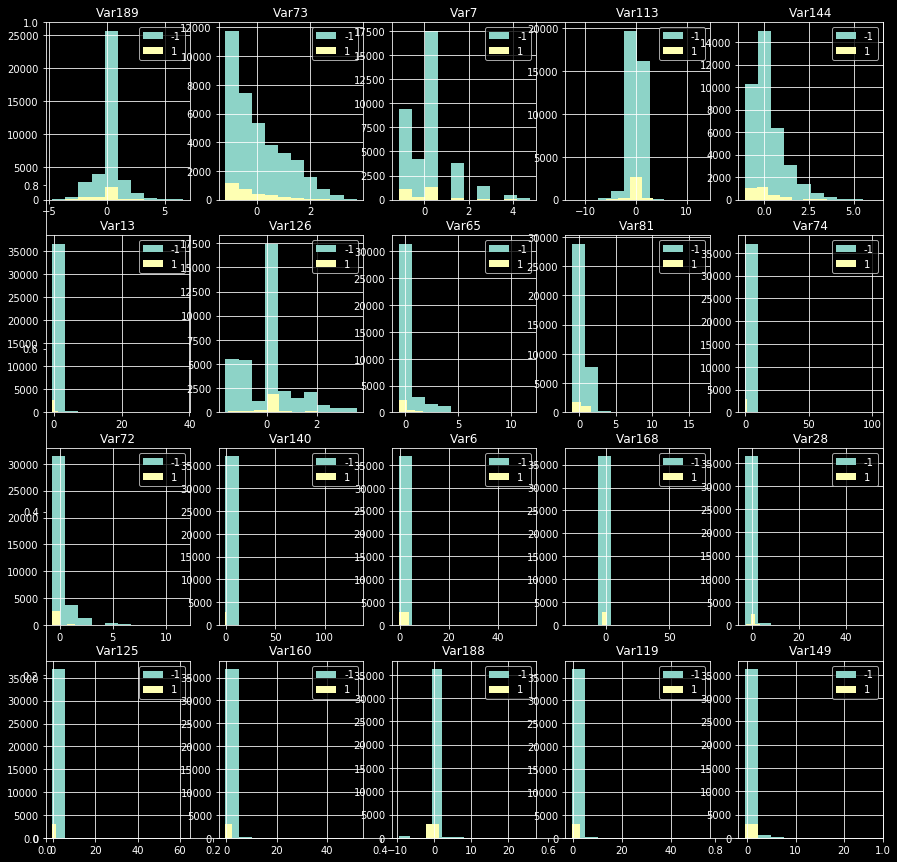

In [315]:
fig = plt.figure(figsize = (15,15));
ax = fig.gca();
for i, col in enumerate(top_20_cont_corr):    
    fig.add_subplot(4, 5, i+1)
    ax = df_all.loc[df_all['target']==-1][col].hist();
    ax = df_all.loc[df_all['target']==1][col].hist();
    ax.set_title(str(col));
    ax.legend(['-1', '1'])

4.3. Распределения в разрезе пар признаков

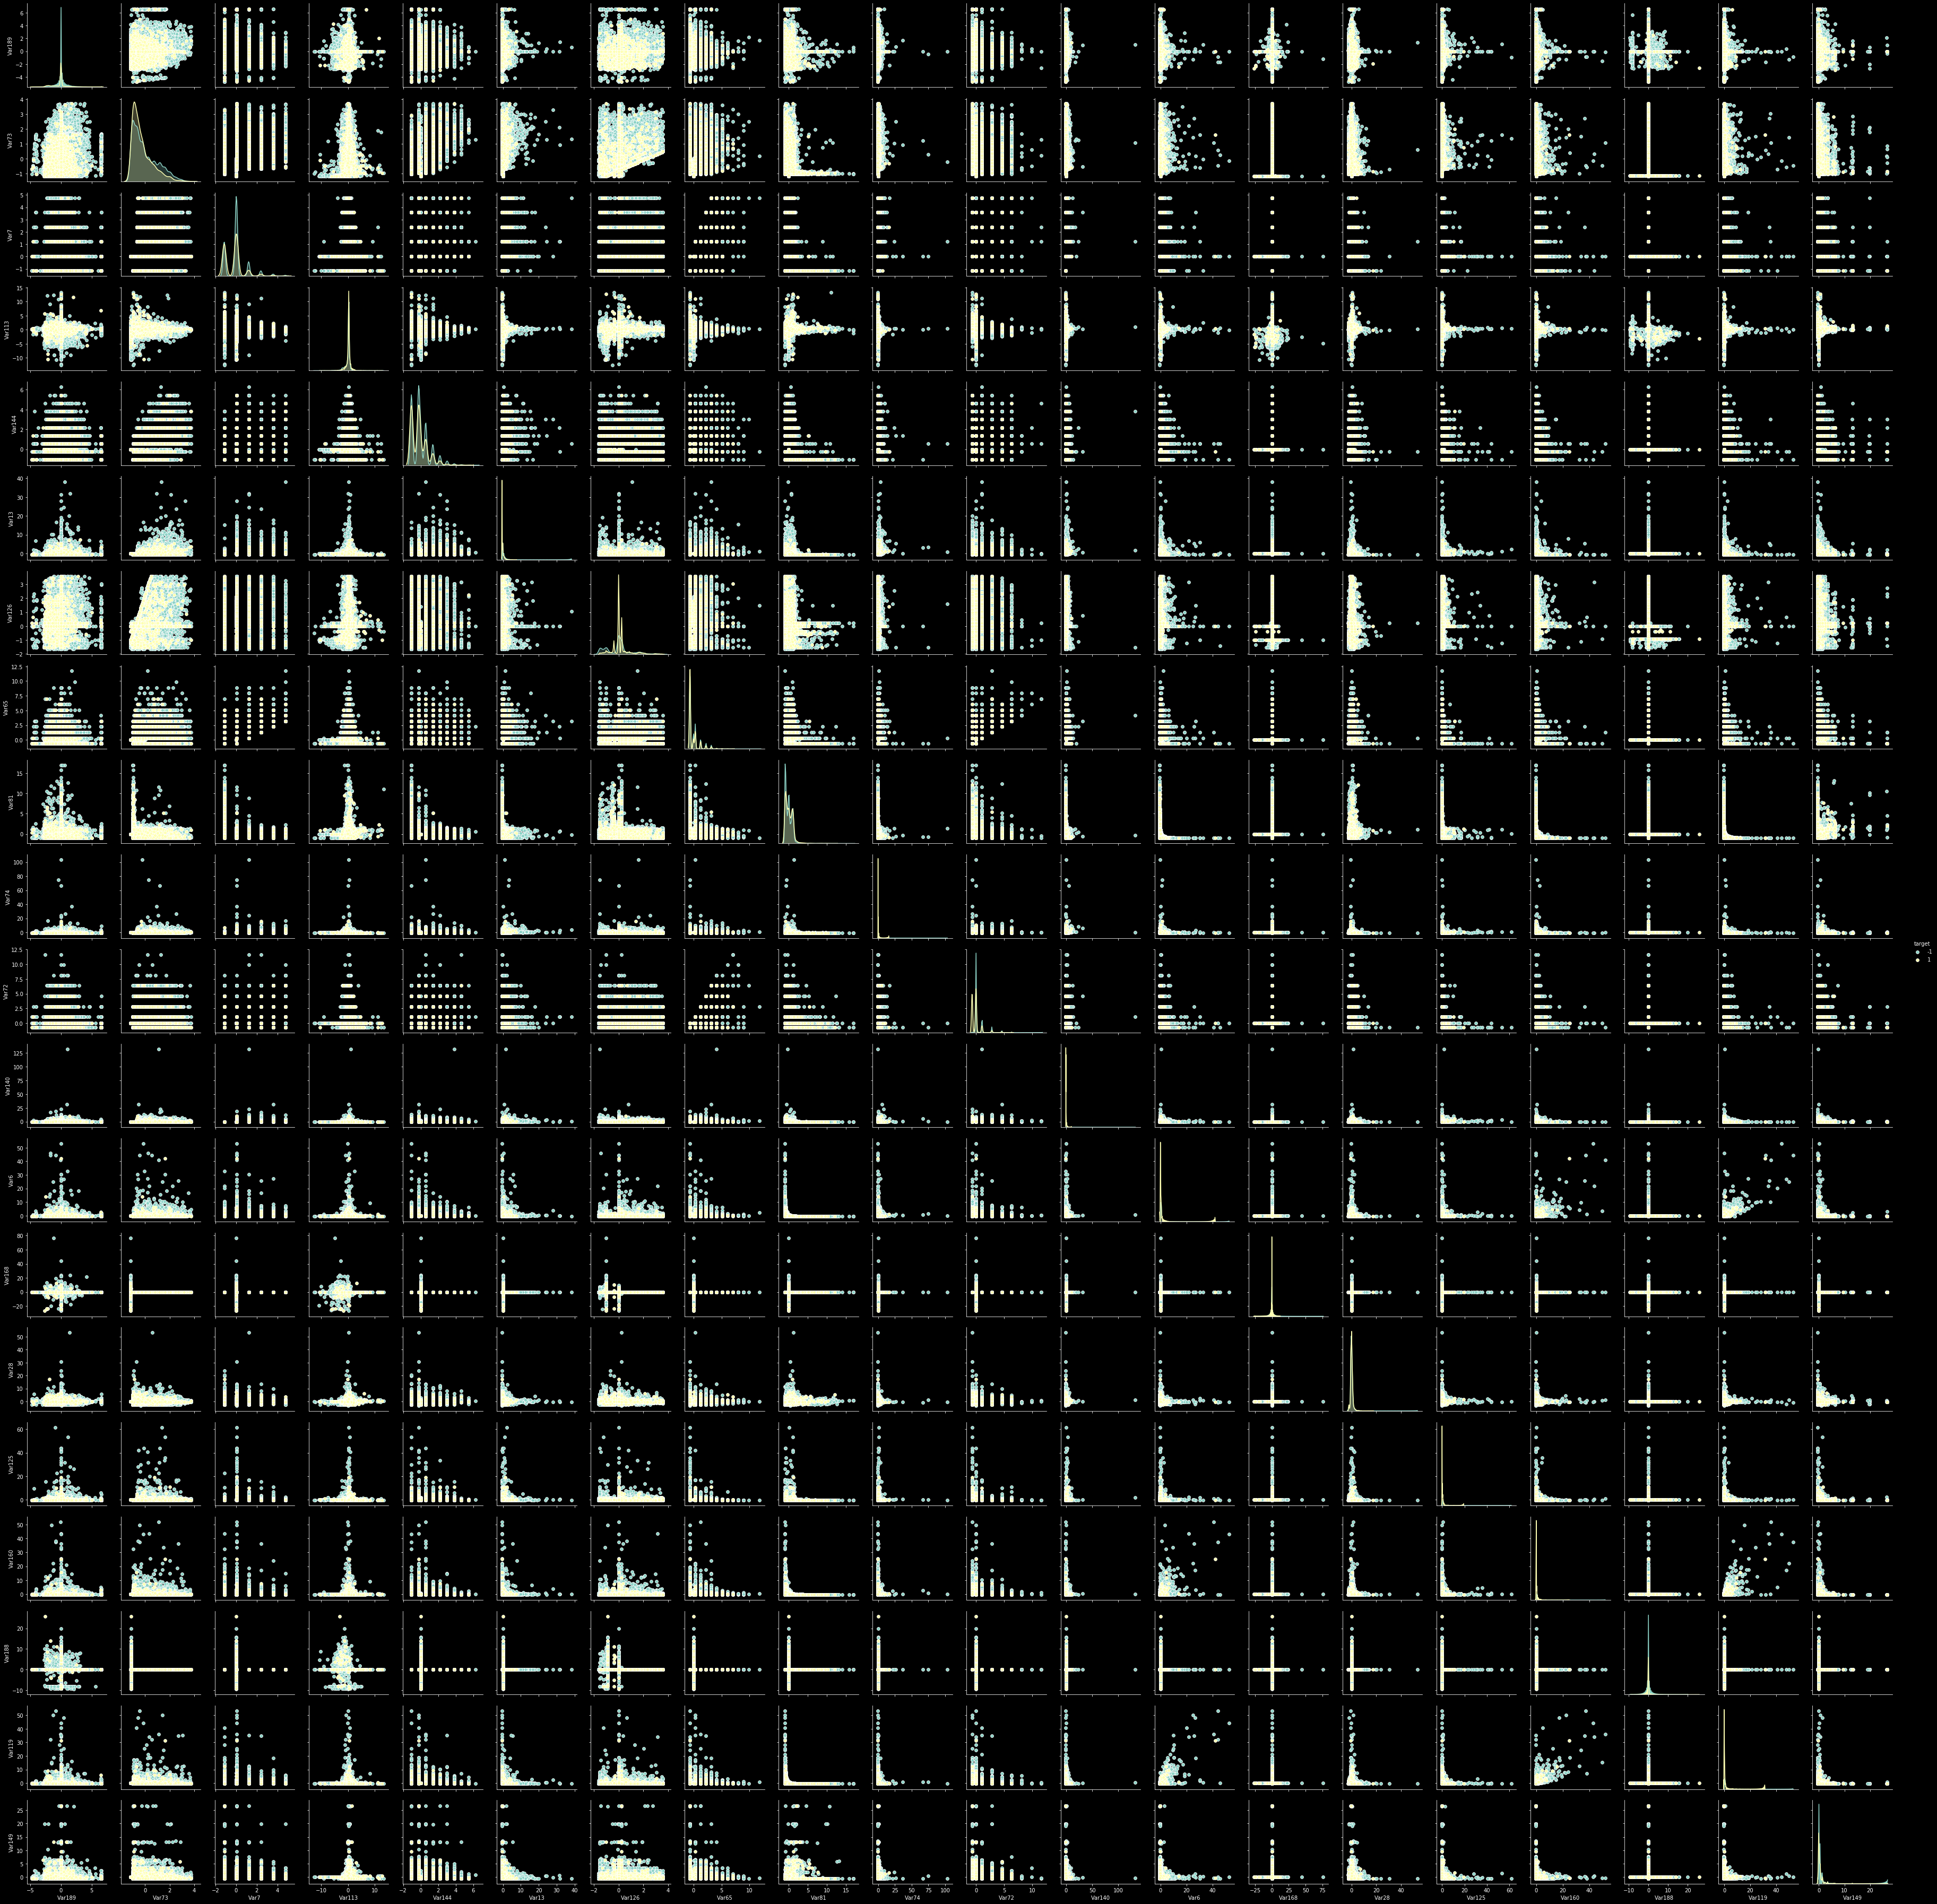

In [325]:
sns.pairplot(data=df_all[list(top_20_cont_corr) + ['target']], vars=df_all[top_20_cont_corr], hue='target');

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

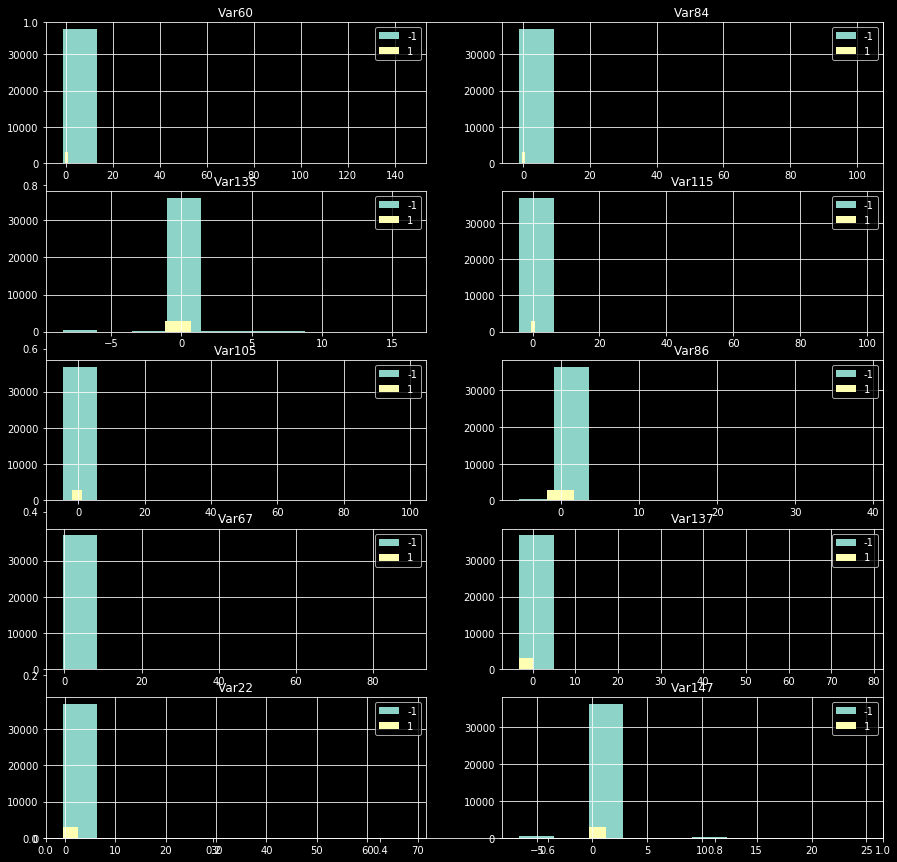

In [326]:
random_col_10 = random.choices(df_all[num_col].columns, k=10)

fig = plt.figure(figsize = (15,15));
ax = fig.gca();
for i, col in enumerate(random_col_10):    
    fig.add_subplot(5, 2, i+1)
    ax = df_all.loc[df_all['target']==-1][col].hist();
    ax = df_all.loc[df_all['target']==1][col].hist();
    ax.set_title(str(col));
    ax.legend(['-1', '1'])

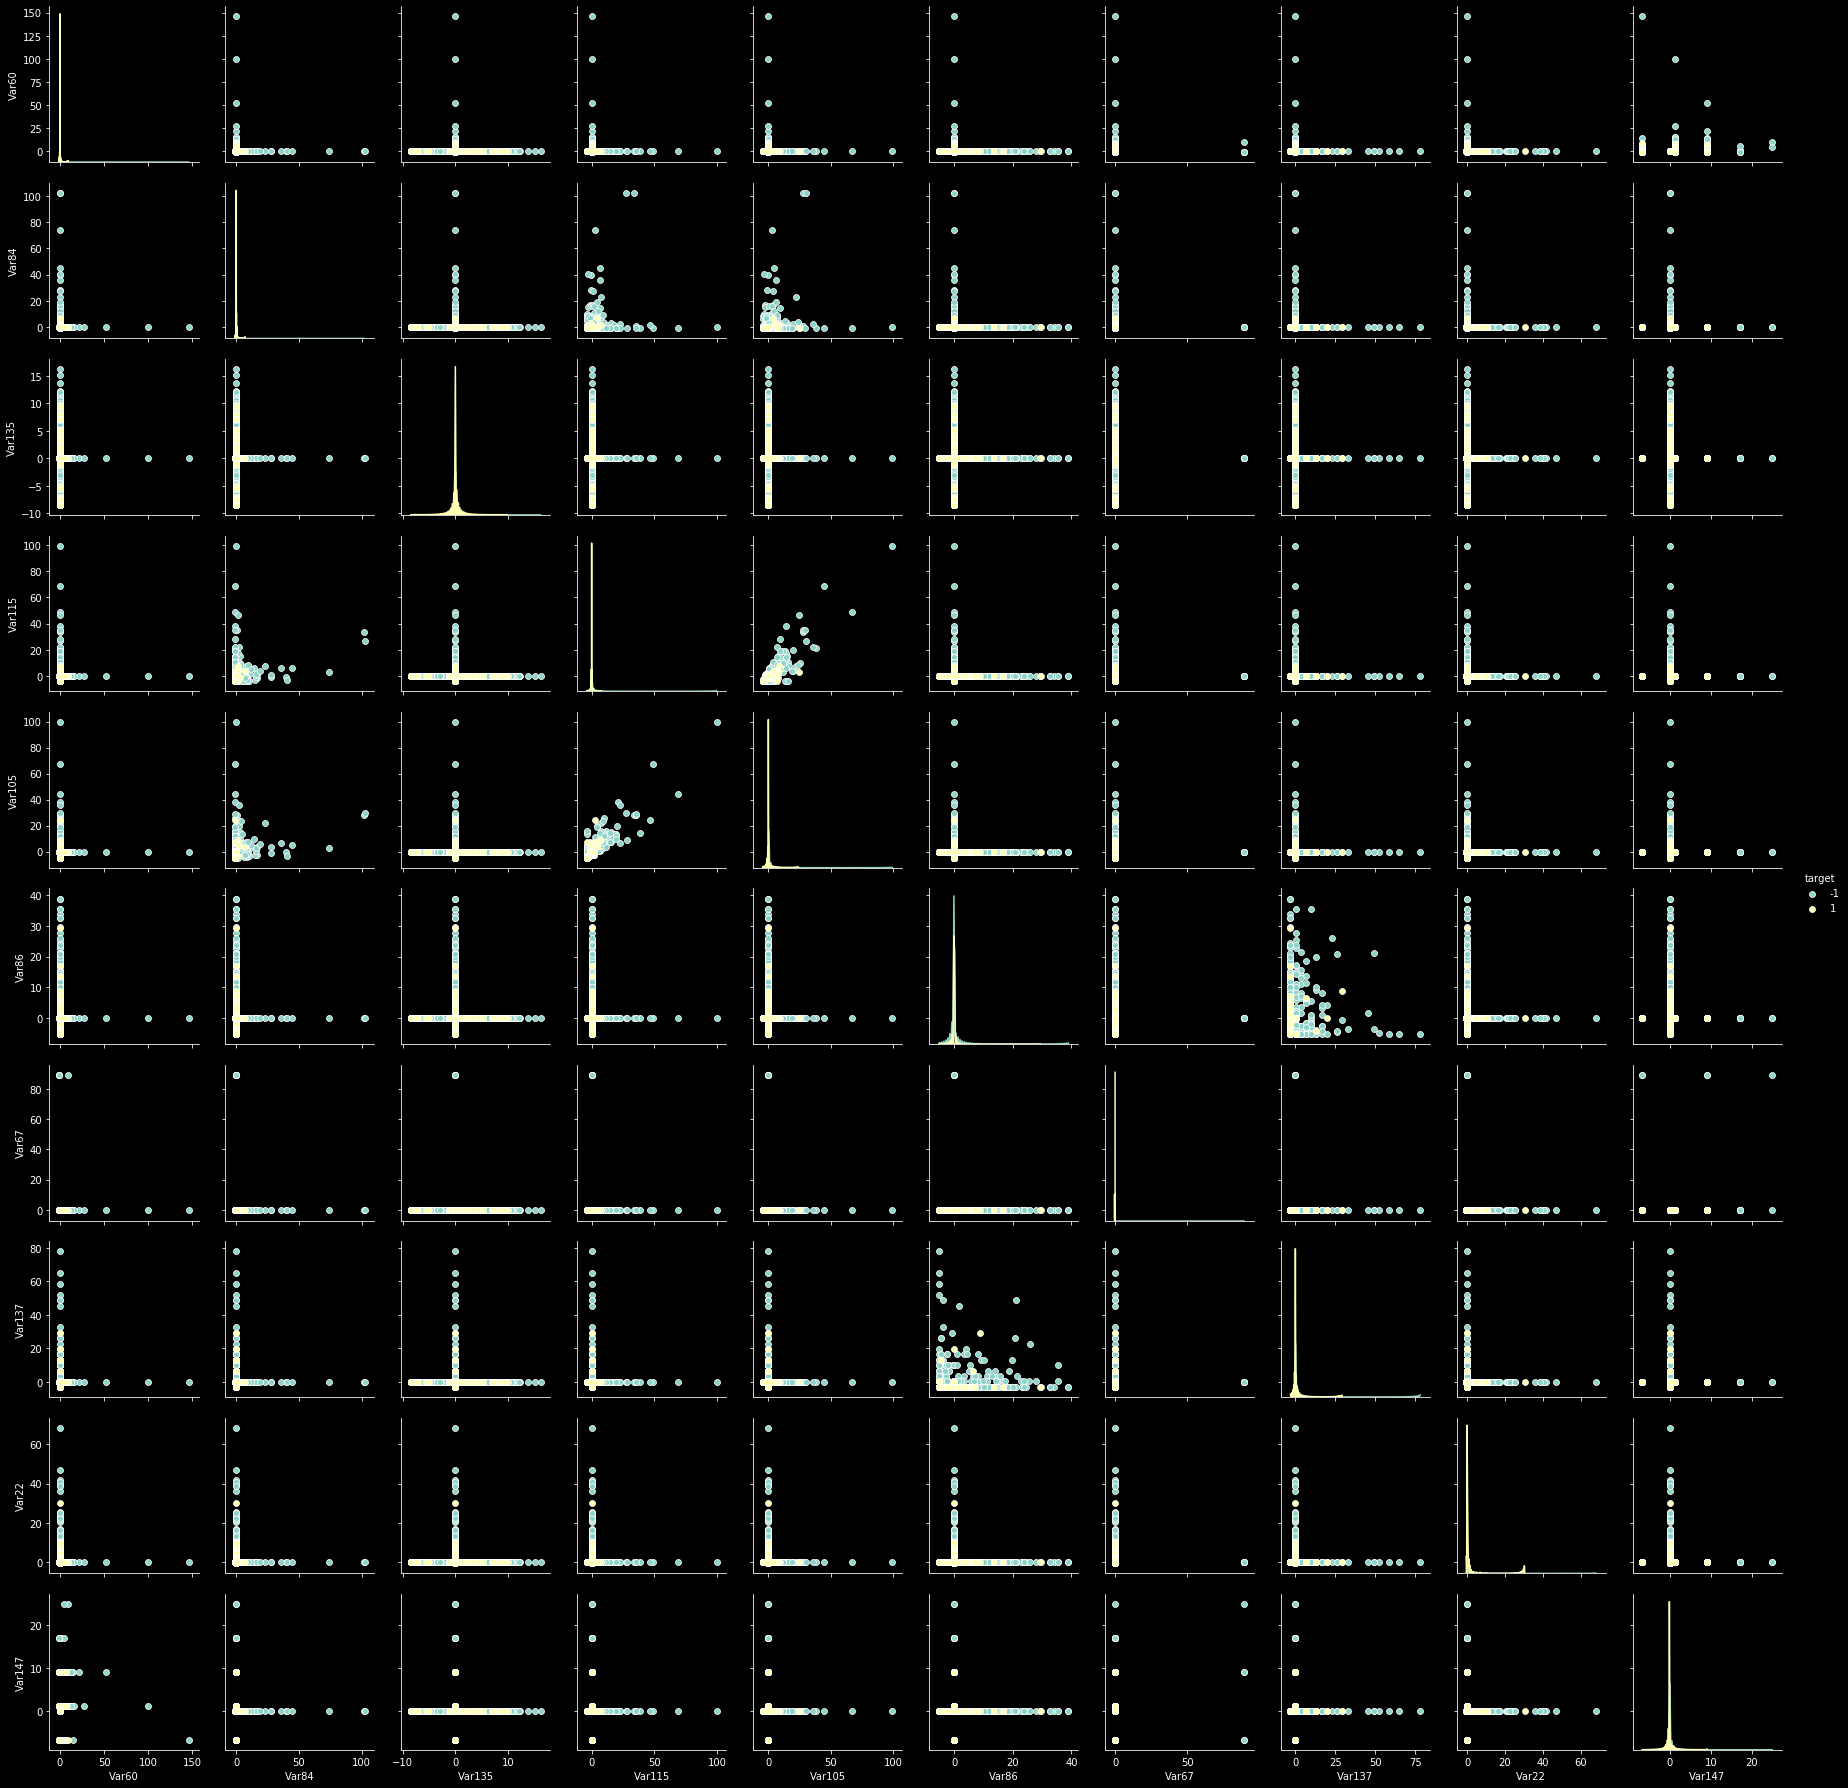

In [327]:
sns.pairplot(data=pd.concat([df_all[random_col_10], df_all['target']], axis=1), vars=df_all[random_col_10], hue='target');

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [328]:
tail_10_cont_corr =  df_cor.tail(10).index
tail_10_cont_corr

Index(['Var58', 'Var4', 'Var121', 'Var16', 'Var64', 'Var146', 'Var123',
       'Var105', 'Var104', 'Var129'],
      dtype='object')

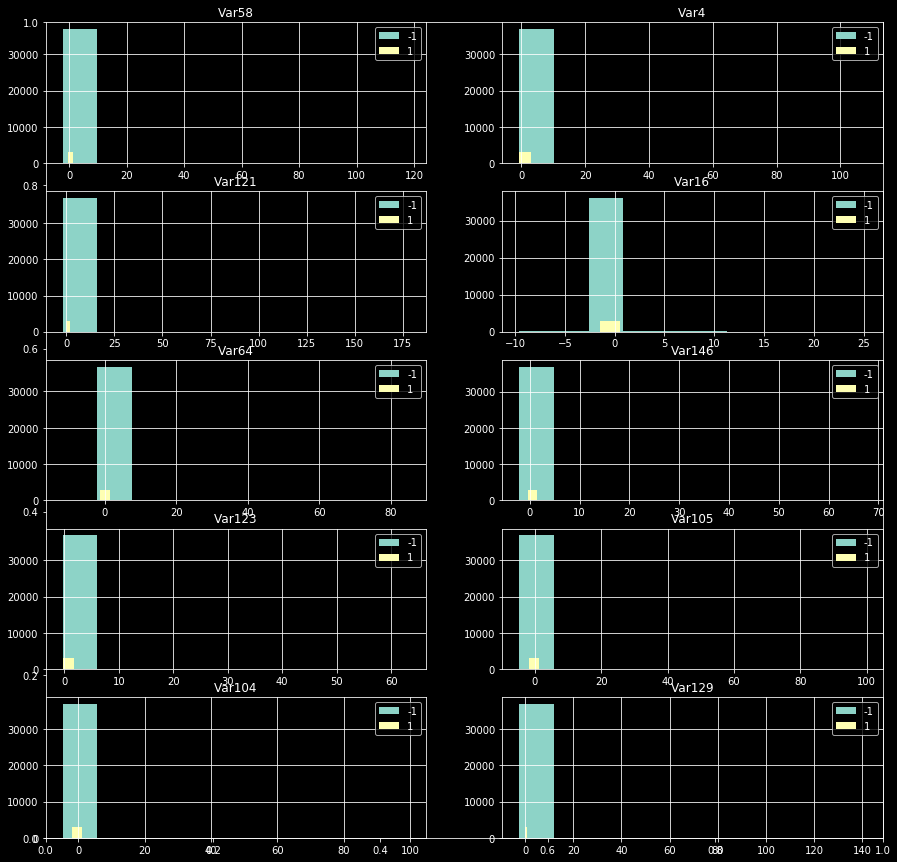

In [329]:
fig = plt.figure(figsize = (15,15));
ax = fig.gca();
for i, col in enumerate(tail_10_cont_corr):    
    fig.add_subplot(5, 2, i+1)
    ax = df_all.loc[df_all['target']==-1][col].hist();
    ax = df_all.loc[df_all['target']==1][col].hist();
    ax.set_title(str(col));
    ax.legend(['-1', '1'])

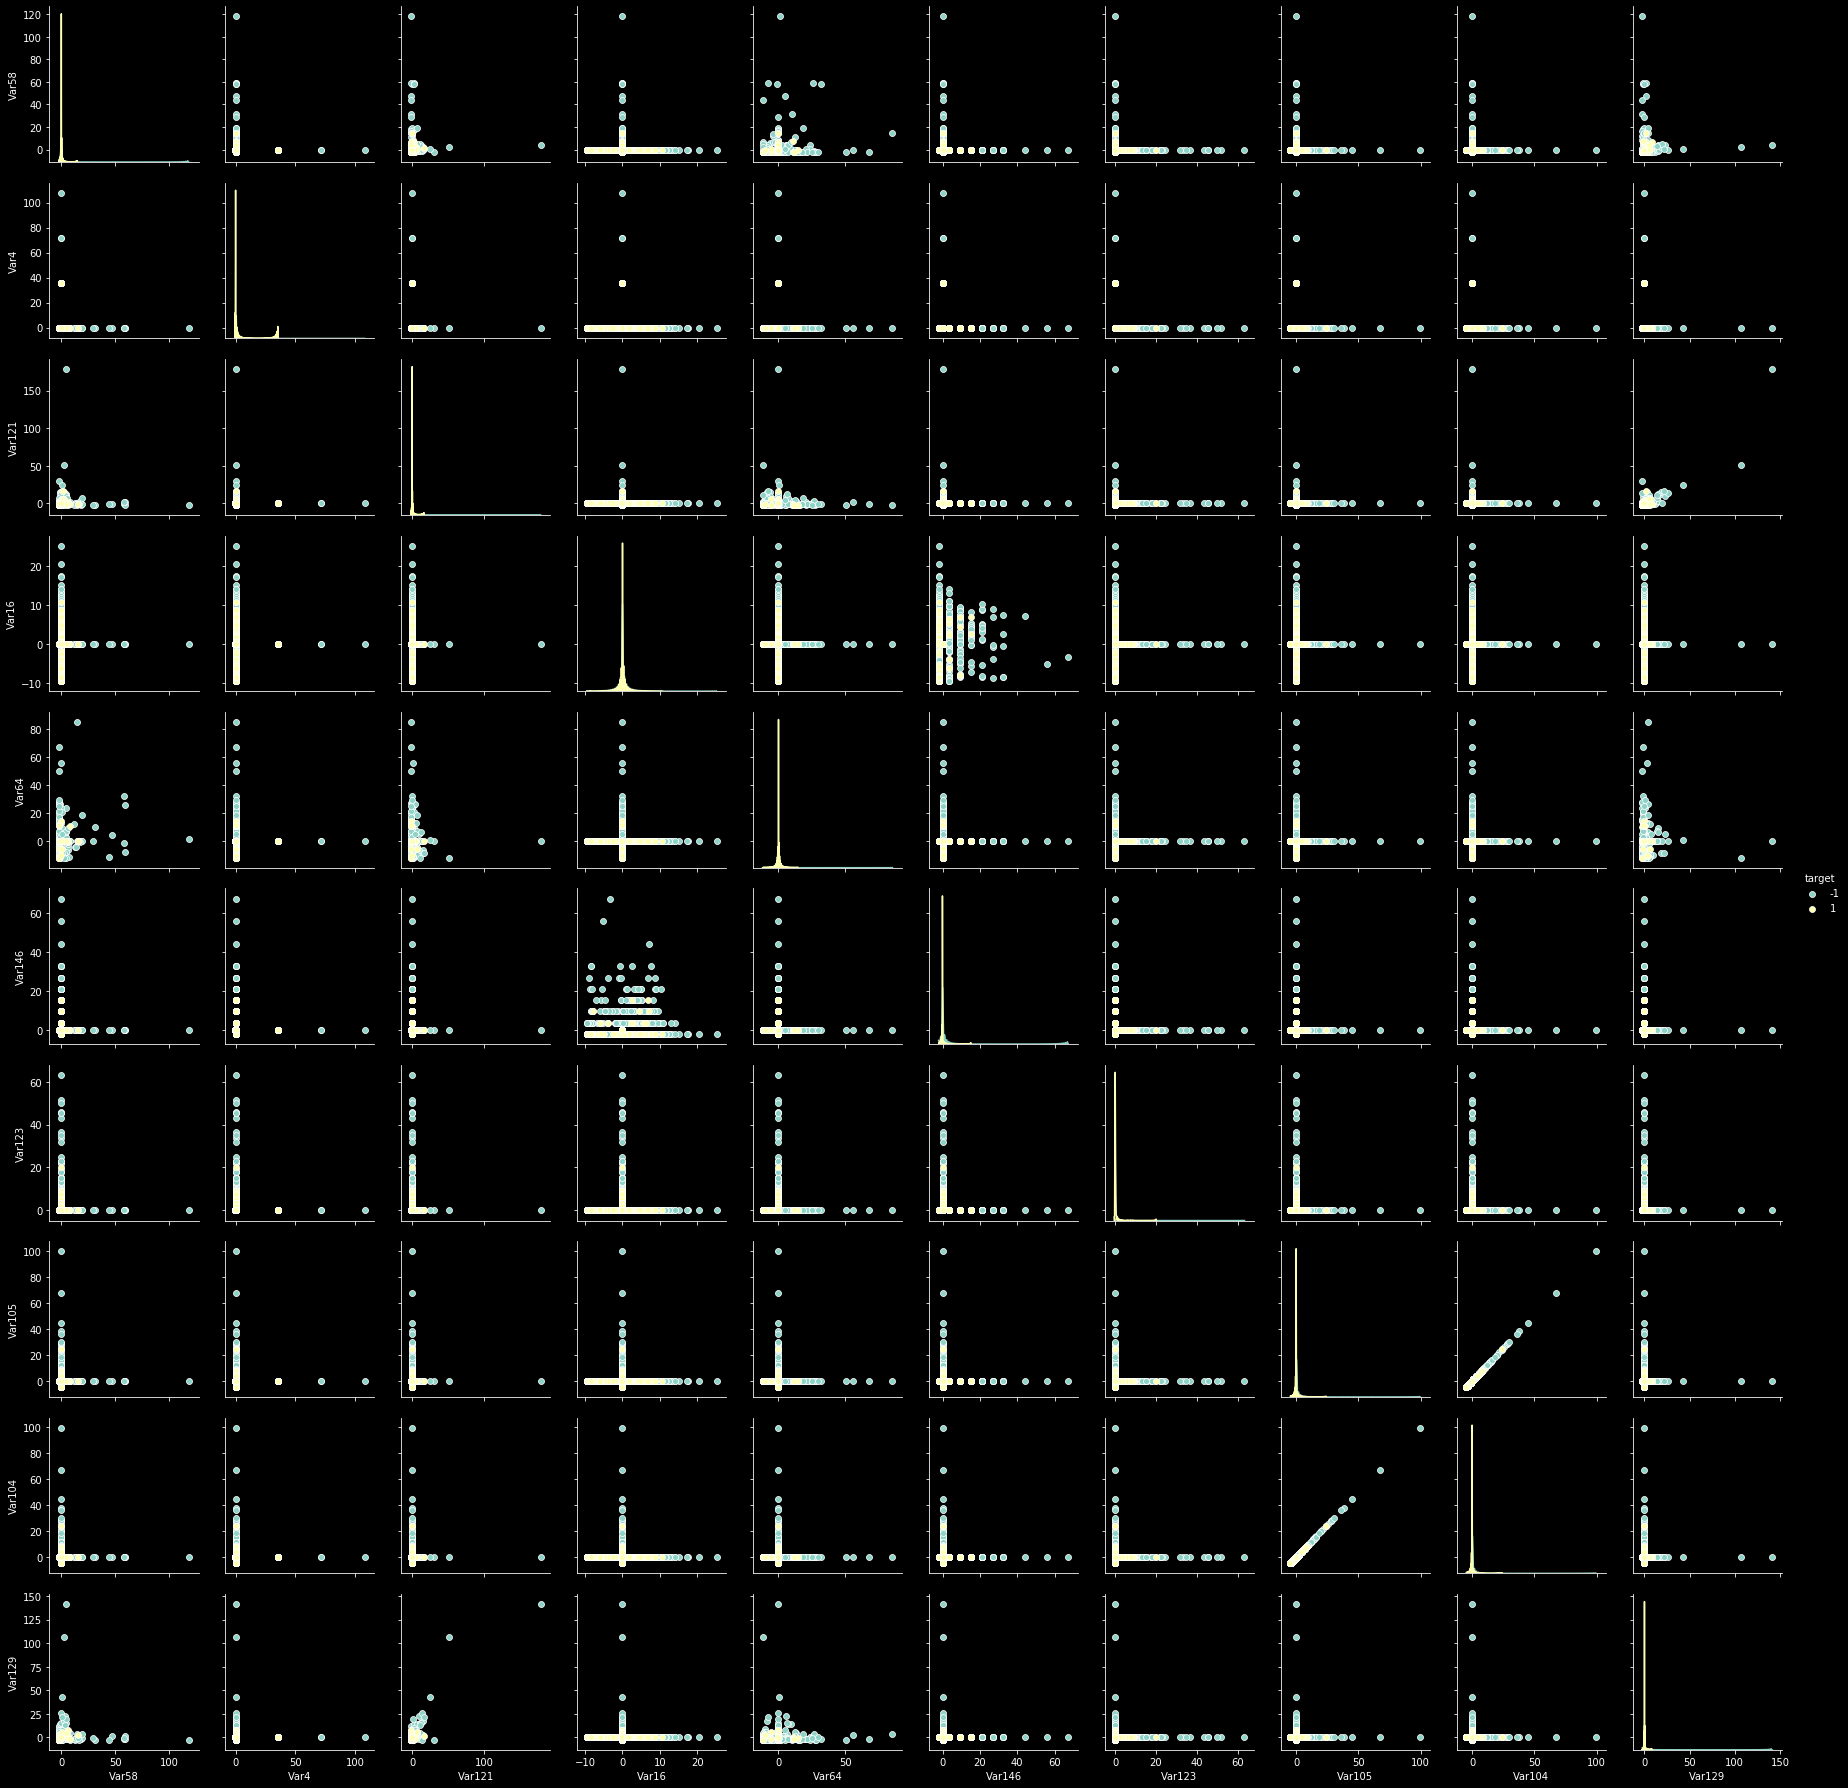

In [330]:
sns.pairplot(data=pd.concat([df_all[tail_10_cont_corr], df_all['target']], axis=1)
             , vars=df_all[tail_10_cont_corr], hue='target');

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

In [331]:
df_category = pd.concat([df_all[category_col], df_all['target']], axis=1)
category_col

Index(['Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var198',
       'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204', 'Var205',
       'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var214',
       'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222',
       'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229'],
      dtype='object')

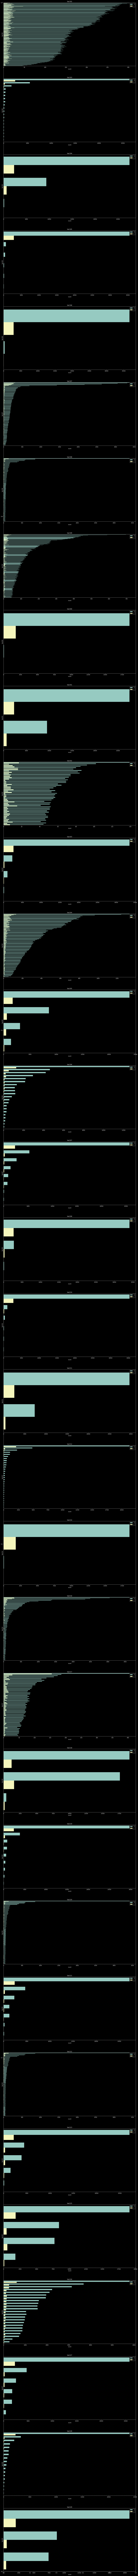

In [334]:
fig = plt.figure(figsize = (20,400));
ax = fig.gca();
for i, col in enumerate(category_col):    
    fig.add_subplot(34, 1, i+1)
    plot_cat = df_category.groupby(col).filter(lambda x: len(x) > 50)    
    orderrr = plot_cat.groupby([col]).size().reset_index().sort_values(0, ascending=False)[col].values
    ax =sns.countplot(y=col, hue="target", order=orderrr, data=plot_cat)
    ax.set_title(str(col));
    ax.legend(['-1', '1'])
    ax.set(yticks=[])

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

1. На гистограммах распределения признаков по классам, в признаках с тяжелым правым хвостом, доля класса оттока, чаще прижимается к 0 (левый край), т.е. не имеют больший численных значений, но в остальном распределения более схожи, чем различны. Наименее полезны будут признаки с меньшей корреляцией и практически одинаковым распределением
2. Визуально выбросов в классе оттока меньше
3. Существуют категориальные признаки, в которых класс оттока принимает всего лишь несколько значений, скорее всего эти категориальные признаки будут значимы (193-196)
4. Категориальные признаки с большим кол-вом значений скорее окажутся шумовыми, чем полезными.
5. Отбор признаков следует пробовать.